사용 중인 디바이스: cuda
기존 모델 'C:\baramproject\trained_model\sibal9\dqn_PER_navigation_model.pth'를 불러왔습니다. 재학습을 시작합니다.


학습 진행률:   0%|          | 0/300 [00:00<?, ?it/s]

Episode 100 - 중간 경로 시각화


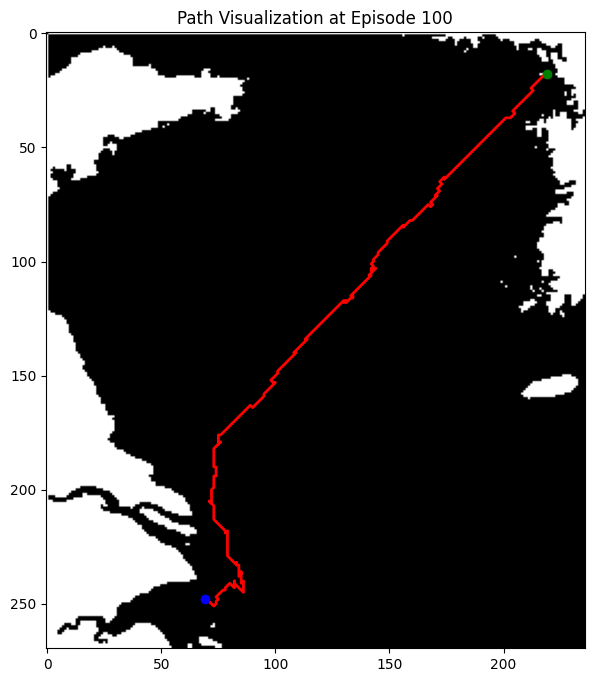

Episode 200 - 중간 경로 시각화


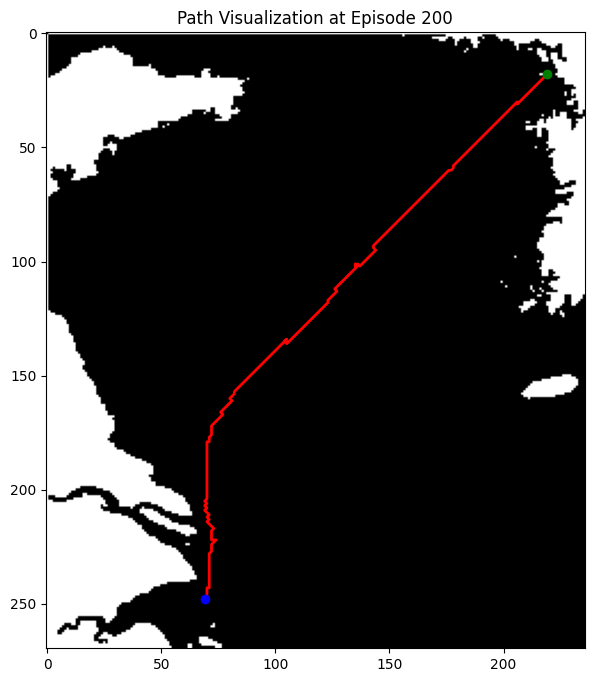

모델이 'dqn_PER_navigation_model.pth' 파일로 저장되었습니다.


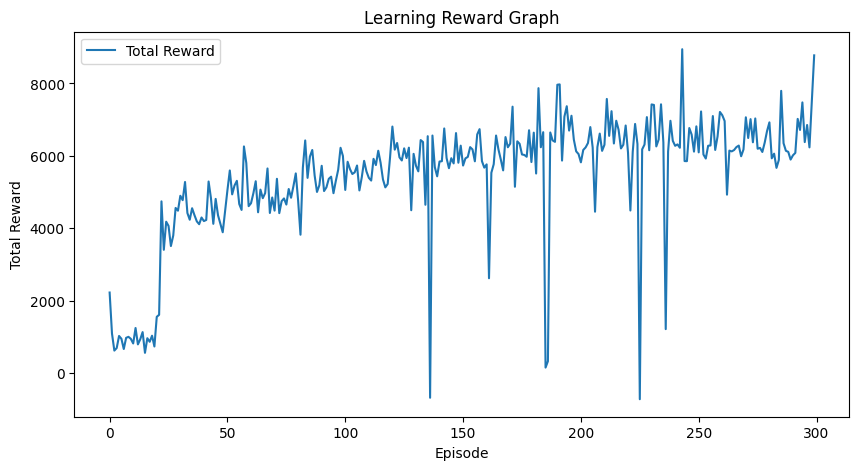

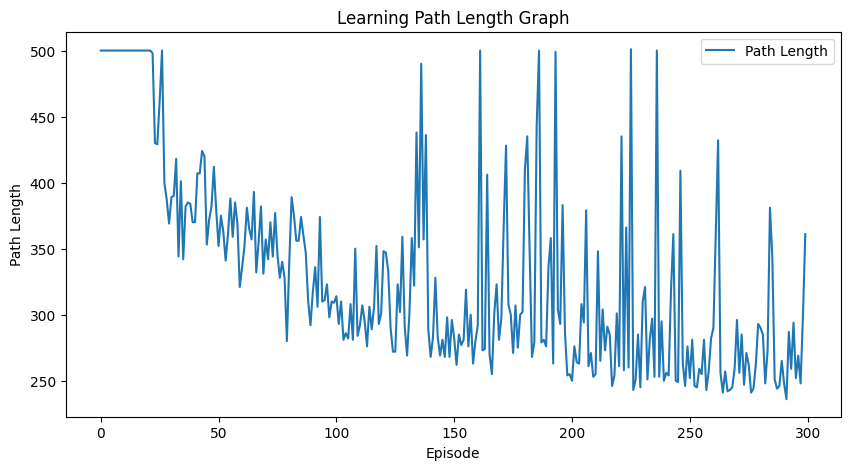

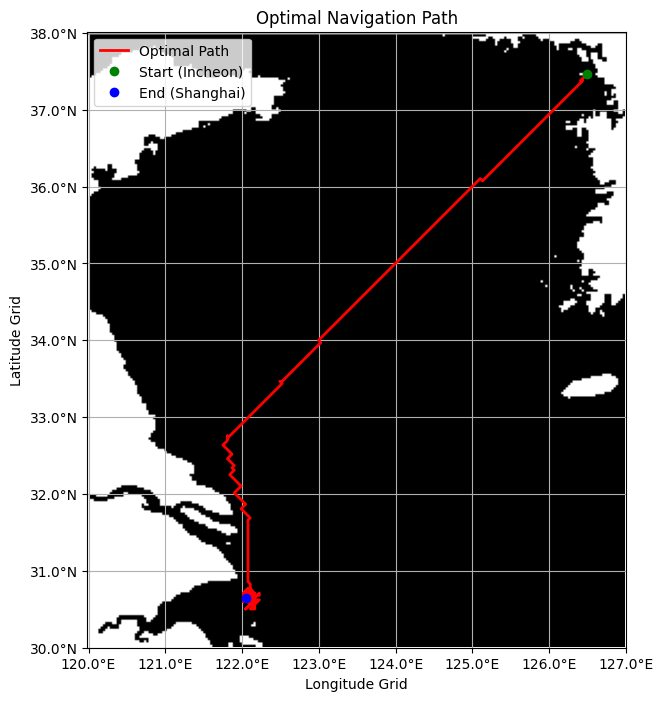

In [17]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# CUDA 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 1. 그리드 맵 로드
grid = np.load(r'C:/baramproject/sibal/land_sea_grid_cartopy_downsized.npy')
n_rows, n_cols = grid.shape  # 270x236

# 2. 좌표 변환 함수
def latlon_to_grid(lat, lon, lat_min=30, lat_max=38, lon_min=120, lon_max=127):
    row = int((lat_max - lat) / (lat_max - lat_min) * n_rows)
    col = int((lon - lon_min) / (lon_max - lon_min) * n_cols)
    return min(max(row, 0), n_rows-1), min(max(col, 0), n_cols-1)

# 시작점과 종료점 설정
start_lat, start_lon = 37.46036, 126.52360  # 인천항
end_lat, end_lon = 30.62828, 122.06400     # 상하이항
start_pos = latlon_to_grid(start_lat, start_lon)
end_pos = latlon_to_grid(end_lat, end_lon)

# 3. 유클리드 거리 계산 함수
def euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# 4. 환경 클래스 정의 (방향 정보 포함)
class NavigationEnv:
    def __init__(self, grid, start_pos, end_pos):
        self.grid = grid
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.current_pos = start_pos
        self.actions = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]
        self.visit_count = {}
        self.prev_action = None  # 이전 방향 추적

    def reset(self):
        self.current_pos = self.start_pos
        self.visit_count = {}
        self.prev_action = None
        return self.get_state()

    def get_state(self):
        prev_action_idx = self.actions.index(self.prev_action) if self.prev_action else -1
        return (self.current_pos[0], self.current_pos[1], prev_action_idx)

    def step(self, action):
        move = self.actions[action]
        new_pos = (self.current_pos[0] + move[0], self.current_pos[1] + move[1])

        if (0 <= new_pos[0] < n_rows and 0 <= new_pos[1] < n_cols and self.grid[new_pos] == 0):
            prev_dist = euclidean_distance(self.current_pos, self.end_pos)
            self.current_pos = new_pos
            new_dist = euclidean_distance(self.current_pos, self.end_pos)

            dist_change = prev_dist - new_dist
            reward = dist_change * 20 if abs(dist_change) >= 0.05 else 0
            reward -= 2  # 스텝당 페널티

            # 종료점 근처에서 거리 기반 가변 보상
            if new_dist < 10:
                # 종료점에 가까울수록 더 큰 보상 (최대 50)
                proximity_bonus = 50 * (1 - new_dist / 10)
                reward += proximity_bonus

            # 방향 전환 페널티
            if self.prev_action is not None and self.prev_action != move:
                reward -= 10

            if self.current_pos == self.end_pos:
                reward += 1000
                done = True
            else:
                done = False

            pos_tuple = tuple(self.current_pos)
            self.visit_count[pos_tuple] = self.visit_count.get(pos_tuple, 0) + 1
            if self.visit_count[pos_tuple] > 3:
                reward -= 10 * (self.visit_count[pos_tuple] - 3)

            self.prev_action = move

        else:
            reward = -10
            done = False

        return self.get_state(), reward, done

# 5. DQN 모델 정의
class DQN(nn.Module):
    def __init__(self, input_dim=3, output_dim=8):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 6. SumTree 클래스 정의 (PER용)
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

# 7. PrioritizedReplayBuffer 클래스 정의 (PER용)
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.epsilon = 0.01
        self.capacity = capacity

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if done:
            priority = 100.0
        else:
            priority = np.max(self.tree.tree[-self.tree.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(priority, data)

    def sample(self, batch_size, beta=0.4):
        batch = []
        idxs = []
        segment = self.tree.total() / batch_size
        priorities = []

        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        sampling_probabilities = priorities / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -beta)
        is_weights /= is_weights.max()

        return batch, idxs, is_weights

    def update(self, idxs, errors):
        for idx, error in zip(idxs, errors):
            p = (abs(error) + self.epsilon) ** self.alpha
            self.tree.update(idx, p)

    def __len__(self):
        return self.tree.n_entries

# 8. 학습 설정
env = NavigationEnv(grid, start_pos, end_pos)
model = DQN(3, 8).to(device)
target_model = DQN(3, 8).to(device)

# 모델 로드 또는 새로 초기화
model_path = r'C:\baramproject\trained_model\sibal9\dqn_PER_navigation_model.pth'
if os.path.exists(model_path):
    try:
        model.load_state_dict(torch.load(model_path))
        target_model.load_state_dict(model.state_dict())
        print(f"기존 모델 '{model_path}'를 불러왔습니다. 재학습을 시작합니다.")
        epsilon = 0.5
        num_episodes = 300
    except Exception as e:
        print(f"모델 로드 실패: {e}. 새로 학습을 시작합니다.")
        target_model.load_state_dict(model.state_dict())
        epsilon = 1.0
        num_episodes = 1000
else:
    print(f"모델 파일 '{model_path}'가 없습니다. 새로 학습을 시작합니다.")
    target_model.load_state_dict(model.state_dict())
    epsilon = 1.0
    num_episodes = 1000

optimizer = optim.Adam(model.parameters(), lr=0.001)
replay_buffer = PrioritizedReplayBuffer(10000)  # 오류 발생 지점 수정
batch_size = 64
gamma = 0.99
epsilon_min = 0.01
epsilon_decay = 0.99
alpha = 0.6
beta = 0.4

# 9. 학습 루프
rewards = []
path_lengths = []
progress_bar = tqdm(range(num_episodes), desc="학습 진행률")

for episode in progress_bar:
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0
    done = False
    path = [state.cpu().numpy()[:2]]  # 위치 정보만 저장
    max_steps = 500
    step = 0

    while not done and step < max_steps:
        if random.random() < epsilon:
            action = random.randint(0, 7)
        else:
            with torch.no_grad():
                q_values = model(state)
                action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_reward += reward
        path.append(next_state[:2])

        replay_buffer.add(state, action, reward, next_state_tensor, done)
        state = next_state_tensor

        if len(replay_buffer) >= batch_size:
            batch, idxs, is_weights = replay_buffer.sample(batch_size, beta)
            states, actions, rewards_batch, next_states, dones = zip(*batch)
            
            states = torch.stack(states)
            actions = torch.tensor(actions).to(device)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32).to(device)
            next_states = torch.stack(next_states)
            dones = torch.tensor(dones, dtype=torch.float32).to(device)
            is_weights = torch.tensor(is_weights, dtype=torch.float32).to(device)

            q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_model(next_states).max(1)[0]
            target = rewards_batch + gamma * next_q_values * (1 - dones)

            errors = torch.abs(q_values - target).detach().cpu().numpy()
            loss = (is_weights * nn.MSELoss(reduction='none')(q_values, target)).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            replay_buffer.update(idxs, errors)

        step += 1

    if done:
        path_length = len(path)
        path_lengths.append(path_length)
    else:
        path_lengths.append(max_steps)

    rewards.append(total_reward)
    progress_bar.set_postfix({'Reward': total_reward, 'Path Length': path_lengths[-1]})

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 20 == 0:
        target_model.load_state_dict(model.state_dict())

    if episode % 100 == 0 and episode > 0:
        print(f"Episode {episode} - 중간 경로 시각화")
        plt.figure(figsize=(10, 8))
        plt.imshow(grid, cmap='gray', origin='upper')
        path_rows = [pos[0] for pos in path]
        path_cols = [pos[1] for pos in path]
        plt.plot(path_cols, path_rows, 'r-', linewidth=2)
        plt.plot(start_pos[1], start_pos[0], 'go')
        plt.plot(end_pos[1], end_pos[0], 'bo')
        plt.title(f"Path Visualization at Episode {episode}")
        plt.show()

# 10. 모델 저장
torch.save(model.state_dict(), r'C:\baramproject\trained_model\sibal9\dqn_PER_navigation_model.pth')
print("모델이 'dqn_PER_navigation_model.pth' 파일로 저장되었습니다.")

# 11. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Reward Graph')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(path_lengths, label='Path Length')
plt.xlabel('Episode')
plt.ylabel('Path Length')
plt.title('Learning Path Length Graph')
plt.legend()
plt.show()

# 12. 최적 경로 시각화 함수
def plot_path(path, start_pos, end_pos, grid):
    path_rows = [pos[0] for pos in path]
    path_cols = [pos[1] for pos in path]
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap='gray', origin='upper')
    plt.plot(path_cols, path_rows, 'r-', linewidth=2, label='Optimal Path')
    plt.plot(start_pos[1], start_pos[0], 'go', label='Start (Incheon)')
    plt.plot(end_pos[1], end_pos[0], 'bo', label='End (Shanghai)')
    lon_ticks = np.linspace(0, n_cols, 8)
    lon_labels = np.linspace(120, 127, 8)
    plt.xticks(lon_ticks, [f"{lon:.1f}°E" for lon in lon_labels])
    lat_ticks = np.linspace(0, n_rows, 9)
    lat_labels = np.linspace(38, 30, 9)
    plt.yticks(lat_ticks, [f"{lat:.1f}°N" for lat in lat_labels])
    plt.xlabel('Longitude Grid')
    plt.ylabel('Latitude Grid')
    plt.title('Optimal Navigation Path')
    plt.legend()
    plt.grid(True)
    plt.show()

# 최적 경로 시각화
plot_path(path, start_pos, end_pos, grid)